In [1]:
import sys
from pathlib import Path 

sys.path.insert(0, Path(__file__).parent.parent.as_posix())

from train.test_final_model import CTGLang
from train.cgru import CGRU
from train.languages_list import Languages
from train.paths import *

from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
from time import time
from matplotlib import pyplot as plt
import torch
import json

import pandas as pd

In [2]:
model = CTGLang("./release/libtglang.so")

In [5]:
gru_bin = CGRU(RESOURCES / "gru_binary.bin", "./release/libgru.so", tokenize=True)
gru_lang = CGRU(RESOURCES / "gru_lang.bin", "./release/libgru.so", tokenize=True)

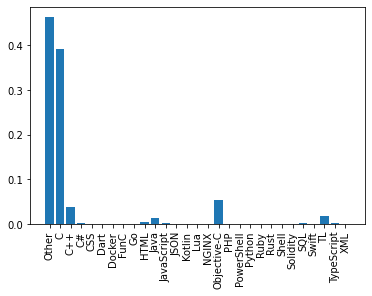

In [45]:
logits = gru_lang.get_logits("array = malloc(10);\n free(array);")

proba = torch.softmax(torch.as_tensor(logits), dim=0)
plt.bar(list(Languages.to_string(lang) for lang in Languages), proba[:29])
plt.xticks(rotation=90);

In [4]:
files = list(Path("./data/extra/").glob("*/*.txt"))

In [7]:
with open("./data/splits.json", "r") as fp:
    splits = json.load(fp)

In [10]:
files = list(Path(file) for file in splits["test_tg"].keys()) + \
        list(Path(file) for file in splits["train_svc"] if splits["train_svc"][file]["origin"] == "tg")

In [12]:
len(files)

6087

In [13]:
predictions = []
is_code = []
texts = []
probas = []

total_time = 0
length = 0

pbar = tqdm(files)
for file in pbar:
    if not file.exists():
        continue

    text = file.read_text()
    texts.append(text)
    
    length += len(text.encode("utf-8"))

    start = time()
    prediction = model(text)
    total_time += time() - start

    logits = gru_bin.get_logits(text)
    proba = torch.softmax(torch.as_tensor(logits), dim=0)[1].item()
    probas.append(proba)

    predictions.append(prediction)
    is_code.append(file.stem.split("-")[-1] == "CODE")

    speed = total_time / length * 4096 * 1000
    pbar.set_description(f"Inference speed per 4kB: {speed:.3f} ms")

predictions = np.array(predictions)
is_code = np.array(is_code)

misses = predictions.astype(bool) != is_code

  0%|          | 0/6087 [00:00<?, ?it/s]

In [14]:
files = [file for file in files if file.exists()]

In [15]:
misses = predictions.astype(bool) != is_code.astype(bool)

data = pd.DataFrame(dict(
    file=files,
    text=texts,
    prediction = predictions,
    prediction_str=[Languages.to_string(Languages(prediction)) for prediction in predictions],
    proba_is_code=probas,
    is_code=is_code.astype(int),
    is_miss=misses.astype(int),
    gt_lang=None,
))

data.to_csv("data/test.csv")

In [16]:
(data.is_code == (data.proba_is_code > 0.5)).mean()

0.9763274699983561

In [17]:
(data.is_code == (data.proba_is_code > 0.66)).mean()

0.9796153213874733

In [18]:
(data.is_code == (data.prediction != 0)).mean()

0.9796153213874733

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
roc_auc_score(data.is_code, data.proba_is_code)

0.984569382442298

In [20]:
fpr, tpr, tt = roc_curve(data.is_code, data.proba_is_code)

In [58]:
data.is_miss.sum() / data.is_code.sum()

0.23544303797468355

In [21]:
accuracies = []
f1 = []

# sorter = np.argsort(-data.proba_is_code)

# sorted_gt = data.is_code[sorter]
# sorted_scores = data.proba_is_code[sorter]

# tp = sorted_gt
# acc = 0
# i = 0

for t in tqdm(tt):
    accuracies.append(accuracy_score(data.is_code, data.proba_is_code >= t))
    f1.append(f1_score(data.is_code, data.proba_is_code >= t))

  0%|          | 0/236 [00:00<?, ?it/s]

In [23]:
max(accuracies), max(f1)

(0.979944106526385, 0.8870673952641166)

In [32]:
accuracies[np.argmax(f1)]

0.9796153213874733

In [42]:
t0

0.6659747958183289

(0.8, 1.01)

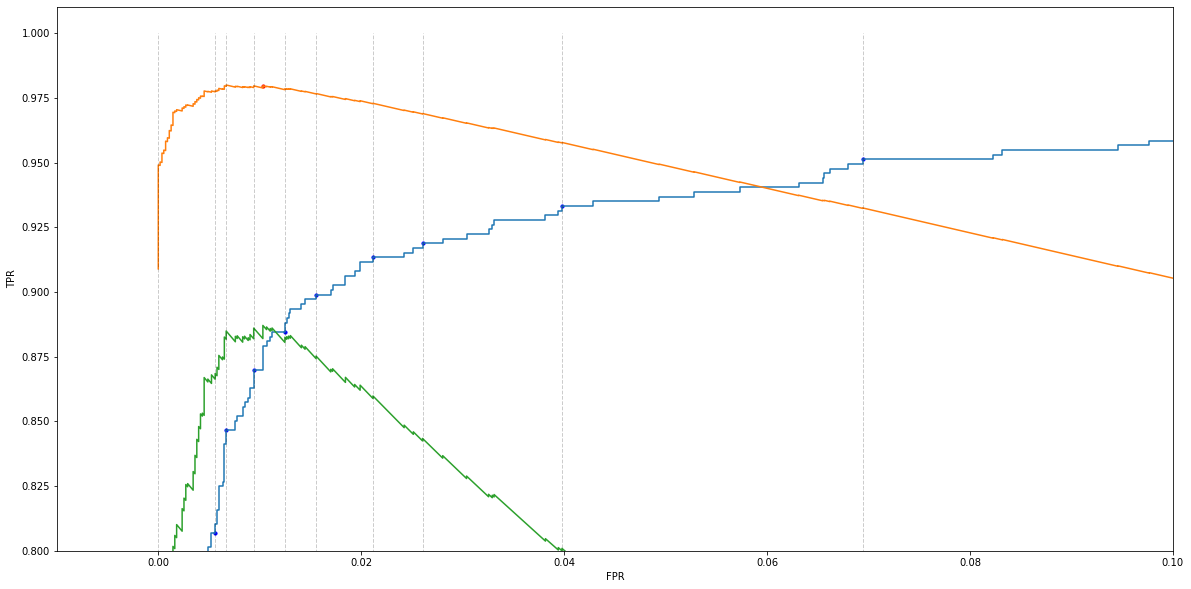

In [41]:
i = np.argmax(f1)
t0 = tt[i]

plt.figure(figsize=[20, 10])

plt.plot(fpr, tpr)
plt.plot(fpr, accuracies)
plt.plot(fpr, f1)
plt.scatter(fpr[i], accuracies[i], s=10, c="red")

for t1 in np.linspace(0, 1, 11):
    i = len(tt) - np.searchsorted(tt[::-1], t1) - 1
    i = min(len(tt) - 1, i)
    i = max(0, i)
    plt.scatter(fpr[i], tpr[i], c="blue", s=10)
    plt.plot([fpr[i], fpr[i]], [0, 1], "--", alpha=0.2, c='black', lw=1)
    # plt.text(fpr[i], tpr[i]-0.03, f"{t1:.1f}")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.xlim(-0.01, 0.1)
plt.ylim(0.8, 1.01)

In [44]:
for _, row in data[data.is_miss == 1].iterrows():
    print('='*10, row["file"], row["prediction_str"], '='*10)
    print(row["text"])

========== data/tg_data/4f/4f344614e17f533e7d7b-CODE.txt Other ==========
GET / HTTP1.1[lf]Host: tim92.com.br[lf]Upgrade: Websocket[lf][lf]
========== data/tg_data/37/37a725d141e301cdaab7-OTHER.txt SQL ==========
LIMITED EDITION
========== data/tg_data/0a/0a9eacea691333a93384-OTHER.txt Python ==========
(WHATAPP/INSTAGRAM/FACEBOOK/TIKTOK/YOUTUBE/TWITTER)


========== data/tg_data/37/3725a7f135ebf597f81b-CODE.txt Other ==========
cscript //nologo %windir%\system32\slmgr.vbs /skms 5.45.97.157:993
cscript //nologo %windir%\system32\slmgr.vbs /ato 9caabccb-61b1-4b4b-8bec-d10a3c3ac2ce
========== data/tg_data/3b/3b7a1ef808b6a5e9c831-OTHER.txt TL ==========
[...]


========== data/tg_data/22/222e2992a05e363384d0-CODE.txt Other ==========
if (условие) {
    тело
}
========== data/tg_data/e2/e230e9931d6425b0ef91-CODE.txt Other ==========
`ls -atr /etc/*-release | tail -2`

========== data/tg_data/bb/bbb3280a328f4147996f-OTHER.txt Python ==========
no main manifest attribute, in gui_compose-1.0-

,file,text,prediction,prediction_str,proba_is_code,is_code,is_miss,gt_lang
54,data/tg_data/4f/4f344614e17f533e7d7b-CODE.txt,GET / HTTP1.1[lf]Host: tim92.com.br[lf]Upgrade...,0,Other,0.080122,1,1,None
224,data/tg_data/37/37a725d141e301cdaab7-OTHER.txt,LIMITED EDITION,24,SQL,0.702847,0,1,None
263,data/tg_data/0a/0a9eacea691333a93384-OTHER.txt,(WHATAPP/INSTAGRAM/FACEBOOK/TIKTOK/YOUTUBE/TWI...,19,Python,0.972321,0,1,None
351,data/tg_data/37/3725a7f135ebf597f81b-CODE.txt,cscript //nologo %windir%\system32\slmgr.vbs /...,0,Other,0.001157,1,1,None
446,data/tg_data/3b/3b7a1ef808b6a5e9c831-OTHER.txt,[...]\n\n,26,TL,0.773536,0,1,None
...,...,...,...,...,...,...,...,...
5795,data/tg_data/f3/f31c5e13344201b4320a-OTHER.txt,PS C:\kotlin\gui_compose> ./gradlew createDist...,24,SQL,0.985900,0,1,None
5831,data/tg_data/bf/bf92ad7d997eb9c6e880-OTHER.txt,Failed to join\nMatrixError: [403] M_FORBIDDEN...,19,Python,0.980343,0,1,None
5836,data/tg_data/46/465dc1f4eff2100d5e4d-CODE.txt,\begin{equation*}\nF(n) =\n \begin{cases}\n ...,0,Other,0.411892,1,1,None
6046,data/tg_data/0d/0d65d0f31a910f48bf58-OTHER.txt,--autounmask-write,24,SQL,0.881638,0,1,None


In [115]:
is_code = []
scores = []

for file in tqdm(files):
    text = file.read_text()
    logits = gru_bin.get_logits(text)
    probas = torch.softmax(torch.as_tensor(logits), dim=0)

    scores.append(probas[1])
    is_code.append(file.stem.split("-")[-1] == "CODE")

scores = np.array(scores)
is_code = np.array(is_code)

  0%|          | 0/23288 [00:00<?, ?it/s]

0.9086862656475783

In [118]:
is_code.mean()

0.08480762624527653

In [119]:
len(is_code)

23288

In [126]:
np.max(accuracies)

0.9636722775678461

In [31]:
i = np.argmax(accuracies)
t0 = tt[i]

In [71]:
accuracy_score(is_code, scores >= t0)

0.9636722775678461

In [39]:
tpr[i], fpr[i]

(0.6587341772151899, 0.008070191901656266)

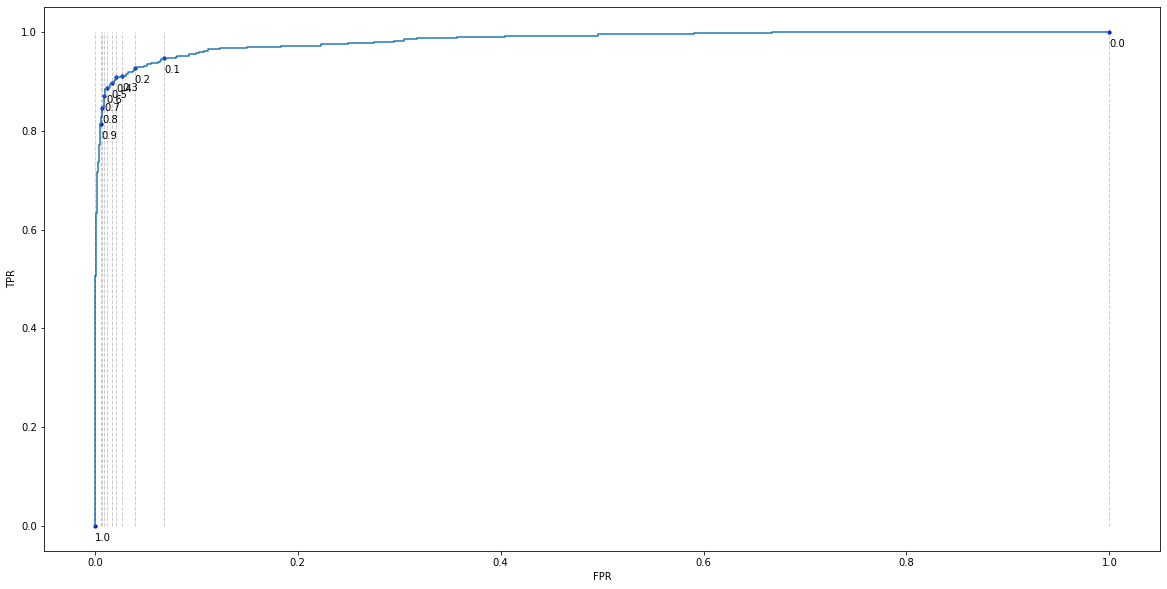

In [67]:
data = pd.read_csv("data/extra.csv")

In [70]:
1 - data.is_miss.mean()

0.9628993473033322

  0%|          | 0/23288 [00:00<?, ?it/s]

In [78]:
1 - misses.mean()

0.9613105462040535

In [129]:
data[misses]

,file,text,prediction,prediction_str,is_code,is_miss,gt_lang
101,data/extra/7b/7bcfc4ddf84804412c46-CODE.txt,function Bird() {\n let hatchedEgg = 10;\n\n ...,0,Other,1,1,None
113,data/extra/7b/7b4b284fe7710053443c-CODE.txt,operator==(const Type&) = default;,0,Other,1,1,None
120,data/extra/7b/7b4ccef739ea526b48f3-CODE.txt,+ <command>\n+--no-progress-meter --location -...,0,Other,1,1,None
176,data/extra/7b/7bac513e459b92e113c8-CODE.txt,"<div id=""preview""></div>\n<input type=""file"" o...",0,Other,1,1,None
178,data/extra/7b/7b532829112afd99dcad-CODE.txt,window\n .matchMedia(this._themeMedia)\n ...,0,Other,1,1,None
...,...,...,...,...,...,...,...
23199,data/extra/e4/e407e0f50a33d962ba83-CODE.txt,"import httpclient\n\necho ""hello!""\n\nlet clie...",0,Other,1,1,None
23217,data/extra/87/87025a27860ff25b5e09-CODE.txt,…\n private void Start()\n {\n Ri...,0,Other,1,1,None
23235,data/extra/87/87e7fe47dd0787d5ced3-CODE.txt,"\non: [push, pull_request]\nname: CI\njobs:\n ...",0,Other,1,1,None
23261,data/extra/87/8717b1711e812c0fa6b1-CODE.txt,"enum FuzzyOption<T> {\n Some(T),\n ProbablyW...",0,Other,1,1,None


In [24]:
print(data.loc[244].text)

<Address>,<quantity>
OP_RETURN <messaggio HEX>, 0


In [33]:
data.to_csv("data/extra.csv")

In [8]:
is_code[misses].mean()

0.8680555555555556

In [30]:
(predictions[misses] == 0).sum()

750

<Languages.CPLUSPLUS: 2>